# Data
In this specfi task i decided to use maritl, jobclass, health and health_ins to predict wage. All of this features will be transformed to dummy variables (like 0/1)

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split

data = load_data('Wage')


X, y = data[['maritl', 'jobclass', 'health', 'health_ins']], data[['wage']]

X

,maritl,jobclass,health,health_ins
0,1. Never Married,1. Industrial,1. <=Good,2. No
1,1. Never Married,2. Information,2. >=Very Good,2. No
2,2. Married,1. Industrial,1. <=Good,1. Yes
3,2. Married,2. Information,2. >=Very Good,1. Yes
4,4. Divorced,2. Information,1. <=Good,1. Yes
...,...,...,...,...
2995,2. Married,1. Industrial,2. >=Very Good,1. Yes
2996,2. Married,1. Industrial,2. >=Very Good,2. No
2997,2. Married,1. Industrial,1. <=Good,2. No
2998,1. Never Married,1. Industrial,2. >=Very Good,1. Yes


## Nominal Values to numbers


In [83]:
def transform_x(row):
    Result = {}

    #Merrige
    Result['merried'] = 1 if row['maritl'] == '2. Married' or row['maritl'] == '5. Separated' else 0
    Result['divorced'] = 1 if row['maritl'] == '4. Divorced' else 0
    Result['Separated'] = 1 if row['maritl'] == '5. Separated' else 0

    #job class
    Result['indrustial'] = 1 if row['jobclass'] == '1. Industrial' else 0

    #health & ins
    Result['health'] = 1 if row['health'] == '2. >=Very Good' else 0
    Result['health_ins'] = 1 if row['health_ins'] == '1. Yes' else 0

    return pd.Series(Result)


X_num = X.apply(transform_x, axis=1)

X_num

,merried,divorced,Separated,indrustial,health,health_ins
0,0,0,0,1,0,0
1,0,0,0,0,1,0
2,1,0,0,1,0,1
3,1,0,0,0,1,1
4,0,1,0,0,0,1
...,...,...,...,...,...,...
2995,1,0,0,1,1,1
2996,1,0,0,1,1,0
2997,1,0,0,1,0,0
2998,0,0,0,1,1,1


## Data Split

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)

x_train

,merried,divorced,Separated,indrustial,health,health_ins
642,0,1,0,0,0,1
700,0,0,0,1,1,1
226,0,0,0,1,1,0
1697,1,0,0,0,1,1
1010,1,0,0,0,1,0
...,...,...,...,...,...,...
1638,1,0,0,0,1,1
1095,1,0,0,1,1,1
1130,1,0,0,0,1,0
1294,1,0,0,0,1,1


## Data Vizualization

## correlation matrix

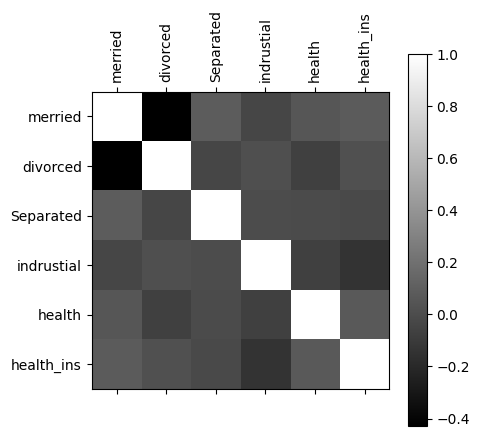

Variance
merried       0.455762
divorced      0.257989
Separated     0.128046
indrustial    0.500054
health        0.452495
health_ins    0.459077
dtype: float64


,merried,divorced,Separated,indrustial,health,health_ins
merried,1.000000,-0.430389,0.084047,-0.038408,0.051176,0.079737
divorced,-0.430389,1.000000,-0.036173,0.015450,-0.070063,0.020718
Separated,0.084047,-0.036173,1.000000,-0.001845,-0.010911,-0.013710
indrustial,-0.038408,0.015450,-0.001845,1.000000,-0.071145,-0.141399
health,0.051176,-0.070063,-0.010911,-0.071145,1.000000,0.076557
health_ins,0.079737,0.020718,-0.013710,-0.141399,0.076557,1.000000


In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

names = X_num.columns
df_features = pd.DataFrame(x_train, columns=names)

corr_mtx = df_features.corr(method='pearson')
plt.matshow(corr_mtx, cmap="grey")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.grid(False)
plt.show()

print('Variance')
print(df_features.std())
corr_mtx

## plotting features vs X

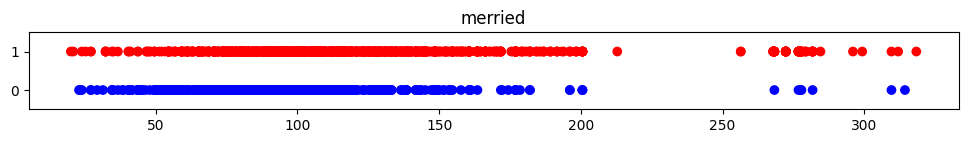

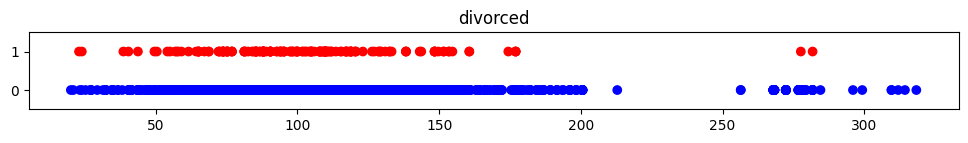

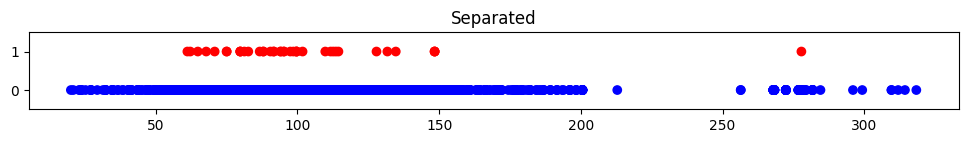

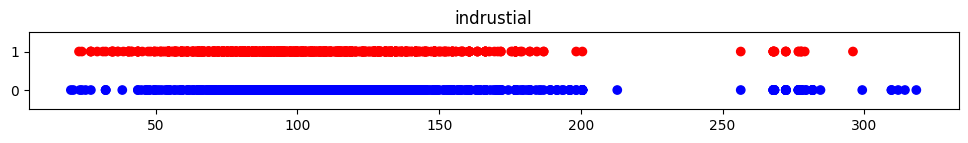

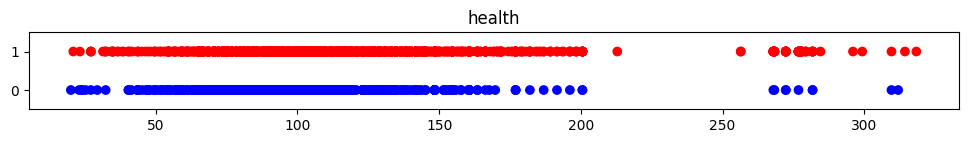

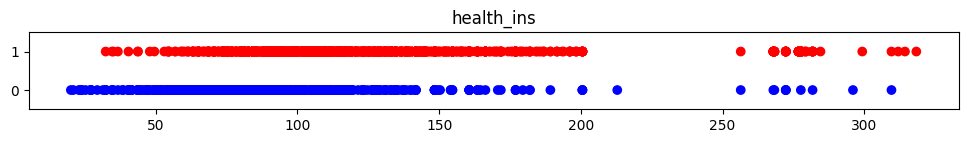

In [86]:
for name in x_train.columns:
    x_plt = x_train[name]
    colors = np.where(x_plt == 1, 'red', 'blue')

    plt.figure(figsize=(12, 1))
    plt.scatter(y_train,x_plt, label=name, c=colors)
    plt.yticks([0, 1])
    plt.ylim(-0.5, 1.5)
    plt.title(name)
    plt.show()

# Model

## Metric Func

In [87]:
from sklearn.metrics import mean_squared_error, r2_score


def metric(y_hat, y_true):
    score = pd.DataFrame({
        'MSE': [mean_squared_error(y_true, y_hat)],
        'RMSE':[np.sqrt(mean_squared_error(y_true, y_hat))],
        'R2': [r2_score(y_true, y_hat)],
    })


    return score

## Model - SVR

In [92]:
from sklearn.svm import SVR

y_train_np = np.array(y_train).ravel()
y_test_np = np.array(y_test.iloc).ravel()



model = SVR()
model.fit(x_train, y_train_np)
metric(model.predict(x_test), y_test)

,MSE,RMSE,R2
0,1266.600677,35.589334,0.187565


### Model optim

In [100]:
from sklearn.model_selection import cross_val_score, KFold
import optuna


def svr_objective(trial: optuna.Trial, cv_folds=None) -> float:


    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = 'scale'

    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"] + list(np.logspace(-4, 0, 5)))

    degree = 3
    if kernel == 'poly':
        degree = trial.suggest_int("degree", 2, 5)

    model = SVR(
        C=C,
        epsilon=epsilon,
        kernel=kernel,
        gamma=gamma,
        degree=degree
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, x_train, y_train_np, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score



study = optuna.create_study(direction="maximize")
study.optimize(svr_objective, n_trials=50, show_progress_bar=True)

study.best_params

[I 2025-12-09 01:16:34,273] A new study created in memory with name: no-name-41d70023-aca2-4204-85fa-d76a16a0c08e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-09 01:16:35,095] Trial 0 finished with value: -1581.018257454244 and parameters: {'C': 0.1190211047423312, 'epsilon': 0.0209138203851669, 'kernel': 'linear'}. Best is trial 0 with value: -1581.018257454244.
[I 2025-12-09 01:16:35,713] Trial 1 finished with value: -1515.4141367401794 and parameters: {'C': 150.32830351730178, 'epsilon': 0.5267352508946087, 'kernel': 'linear'}. Best is trial 1 with value: -1515.4141367401794.
[I 2025-12-09 01:16:36,500] Trial 2 finished with value: -1831.9353717418296 and parameters: {'C': 0.0013214097287918012, 'epsilon': 0.0010525487795267506, 'kernel': 'sigmoid', 'gamma': 0.001}. Best is trial 1 with value: -1515.4141367401794.
[I 2025-12-09 01:16:36,990] Trial 3 finished with value: -1518.1753952448034 and parameters: {'C': 6.428434701150741, 'epsilon': 0.4166290801365856, 'kernel': 'linear'}. Best is trial 1 with value: -1515.4141367401794.
[I 2025-12-09 01:16:37,517] Trial 4 finished with value: -1734.8418791532392 and parameters: {'C': 1

{'C': 65.57069906640906,
 'epsilon': 0.07026269419097794,
 'kernel': 'rbf',
 'gamma': 'scale'}

## Test model

In [101]:
model = SVR(**study.best_params)
model.fit(x_train, y_train_np)

metric(model.predict(x_test), y_test)

,MSE,RMSE,R2
0,1253.813687,35.409232,0.195767
